In [141]:
import spacy
from spacy import displacy
from collections import Counter
from spacy import tokenizer
import nltk

import pandas as pd
import numpy as np
import seaborn as sb

from nltk.corpus import state_union
from nltk.tokenize import PunktSentenceTokenizer
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
nlp = spacy.load('en_core_web_sm')

##nltk.download('words')
##nltk.download('punkt')
##nltk.download('maxent_ne_chunker')
##nltk.download('averaged_perceptron_tagger')
##nltk.download('state_union')##

In [133]:
import io
import math
import requests
import PyPDF2
import spacy
import string
import re
import gensim
from sklearn import svm
from sklearn import metrics

from sklearn.feature_extraction import text
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from pyLDA_visual import topic_visual
from Grid_Search_LDA import lda_gridsearch
from LDAGensim import lda_gensim_model

In [122]:
def get_org(doc):
    for i in doc.ents:
        if i.label_ == "ORG":
            organization = i.text
            return organization

In [123]:
path = './dataset.xlsx'
ds = pd.read_excel(path)
ds.head()


,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,COMPANY_NAME,PILLAR,SUB_PILLAR,CONTROVERSY_ASSESSMENT,STATUS,INVOLVED,FLAG
0,Home Depot workers petition to form 1st store-...,NEW YORK (AP) â€”\n\nHome Depot workers in Phi...,1,20.0,1.0,2.0,NaN,NaN,NaN,NaN,0,0,NaN
1,Ecowas threatens tough sanctions on Guinea,Guinea-Ecowas-Transition-Sanctions Ecowas thre...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN
2,S/African court freezes pension payment for gr...,South Africa-Corruption-Lottery S/African cour...,1,25.0,1.0,1.0,NaN,NaN,NaN,NaN,2,0,NaN
3,Siply Plans To Launch 1000 Phygital Branches R...,The company targets to launch 200 branches in ...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN
4,Denver judge rejects GOP residency complaint a...,A Democrat running to represent a state Senate...,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN


In [124]:
ds["News"] = ds["News"]
ds["News"].count()

69

In [125]:
for index, x in ds.iterrows():
    temp = nlp(x["News"])
    ds.loc[index, "COMPANY_NAME"] = get_org(temp)
    if get_org(temp) == None :
        ds = ds.drop(index)


In [126]:
ds.head()

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,COMPANY_NAME,PILLAR,SUB_PILLAR,CONTROVERSY_ASSESSMENT,STATUS,INVOLVED,FLAG
0,Home Depot workers petition to form 1st store-...,NEW YORK (AP) â€”\n\nHome Depot workers in Phi...,1,20.0,1.0,2.0,AP,NaN,NaN,NaN,0,0,NaN
1,Ecowas threatens tough sanctions on Guinea,Guinea-Ecowas-Transition-Sanctions Ecowas thre...,0,NaN,NaN,NaN,the Economic Community of West African States,NaN,NaN,NaN,1,1,NaN
2,S/African court freezes pension payment for gr...,South Africa-Corruption-Lottery S/African cour...,1,25.0,1.0,1.0,APA-Johannesburg (South Africa,NaN,NaN,NaN,2,0,NaN
3,Siply Plans To Launch 1000 Phygital Branches R...,The company targets to launch 200 branches in ...,0,0.0,NaN,NaN,Phygital,NaN,NaN,NaN,0,1,NaN
4,Denver judge rejects GOP residency complaint a...,A Democrat running to represent a state Senate...,0,0.0,NaN,NaN,Senate,NaN,NaN,NaN,1,0,NaN


In [127]:
stop_words = text.ENGLISH_STOP_WORDS

In [128]:
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2), min_df=0, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(ds.News)

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names_out()

# extract our top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words))

# Plot top 10 ngrams
#plt.figure(figsize=(15, 5))
#plt.subplot(title='10 most common bi-grams')
#sns.barplot(x_pos, counts, palette='Blues_r')
#plt.xticks(x_pos, words, rotation=90)
#plt.xlabel('bi-grams')
#plt.ylabel('tfidf')
#plt.show()

In [129]:
# %% Modeling : NMF (Non Negative Matrix factorization)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

word_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1))
word_tf_idf = word_tf_idf_vectorizer.fit_transform(ds.News)
n_top_words = 20

# Fit the NMF model Frobenius norm
print("Fitting the NMF model (Frobenius norm) with tf-idf feature")
nmf = NMF(n_components=15, random_state=42,
          alpha=.3, l1_ratio=.5).fit(word_tf_idf)

#print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = word_tf_idf_vectorizer.get_feature_names_out()
#print_top_words(nmf, tfidf_feature_names, n_top_words)

Fitting the NMF model (Frobenius norm) with tf-idf feature


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [130]:

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

word_tf_vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1,1))
word_tf = word_tf_vectorizer.fit_transform(ds.News)

# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=5,
                                      learning_decay=0.3,
                                      #max_iter=10,               # Max learning iterations
                                      #learning_method='online',
                                      random_state=42,          # Random state
                                      #batch_size=128,            # n docs in each learning iter
                                      #evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      #n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit(word_tf)

print(lda_model)
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(word_tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(word_tf))

# See model parameters
print(lda_model.get_params())

#print_top_words(lda_model, word_tf_vectorizer.get_feature_names(), 20)

LatentDirichletAllocation(learning_decay=0.3, n_components=5, random_state=42)
Log Likelihood:  -170259.3178786848
Perplexity:  3986.915578238652
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.3, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 5, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [131]:
# %% Gensim LDA for coherence score
#lda_gensim_model(ds) #(stat_lem_list)
# No. of Topics = 9
# Human intution of topic names:
#TOPIC 1(G) : Ethical investment
#TOPIC 2(E): Sustainable finance
#TOPIC 3(S): Value employee
#TOPIC 4(G): Code of Conduct
#TOPIC 5(E): Climate change
#TOPIC 6(E): renewable energy
#TOPIC 7(G): Customer centric
#Topic 8(G): Strong governance
#Topic 9(S): Support community
#topic_names = [  'ethical investment',  'Sustainable finance',  'Value employee',  'Code of Conduct',  'Climate change','renewable energy','Customer centric','Strong governance','Support community']

topic_names = ['Environment',
               'Customers',
               'Human rights and community',
               'Labor rights and suppy chain',
               'Governance'
              ]

              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78         9
         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         3

    accuracy                           0.64        14
   macro avg       0.21      0.33      0.26        14
weighted avg       0.41      0.64      0.50        14



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


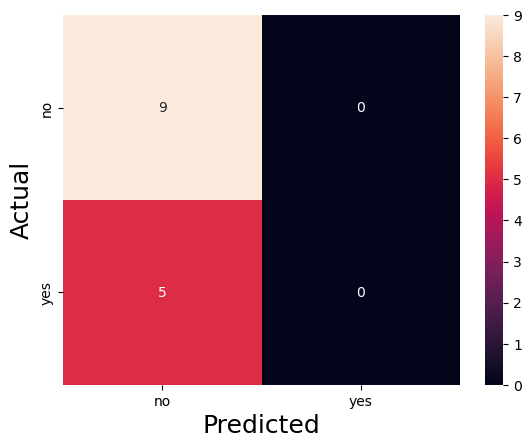

In [153]:
x_train5, x_test5, y_train5, y_test5 = train_test_split(word_tf, ds.ESG_RELEVANT, test_size=0.2, random_state=42)
model_svc5 = svm.LinearSVC(multi_class='crammer_singer')
model_svc5.fit(x_train5,y_train5)

y_pred5= model_svc5.predict(x_test5)
print(metrics.classification_report(y_test,y_pred))
conf_matrix(y_test5, y_pred5)

In [151]:
def conf_matrix(y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred, labels=[0,1])
    labels=["no","yes"]
    hm = sb.heatmap(cm, annot=True, xticklabels=labels, yticklabels = labels)
    hm.set_xlabel("Predicted" , size =18)
    hm.set_ylabel("Actual", size =18)

In [106]:
#%% Topic Distribution for each of the statements

transformed = lda_model.transform(word_tf)
# find principal topic from distribution...
a = [topic_names[np.argmax(distribution)] for distribution in transformed]
# ... with associated probability
b = [np.max(distribution) for distribution in transformed]
 
ds["SCALE"] = ds["SCALE"].fillna(0)
ds["NATURE_OF_HARM"] = ds["NATURE_OF_HARM"].fillna(0)
esg_prob = pd.DataFrame(zip(a,b,transformed), columns=['SUB_PILLAR', 'probability', 'probabilities'])
ds["SUB_PILLAR"] = a


In [107]:
x_train, x_test, y_train, y_test = train_test_split(word_tf, ds.NATURE_OF_HARM, test_size=0.2, random_state=42)
model_svc = svm.LinearSVC(multi_class='crammer_singer')
model_svc.fit(x_train,y_train)

y_pred= model_svc.predict(x_test)
print(y_pred)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [108]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(word_tf, ds.SCALE, test_size=0.2, random_state=42)
model_svc2 = svm.LinearSVC(multi_class='crammer_singer')
model_svc2.fit(x_train2,y_train2)

y_pred2= model_svc2.predict(x_test2)
print(y_pred2)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [109]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(word_tf, ds.STATUS, test_size=0.2, random_state=42)
model_svc3 = svm.LinearSVC(multi_class='crammer_singer')
model_svc3.fit(x_train3,y_train3)

y_pred3= model_svc3.predict(x_test3)
print(y_pred3)

[1 2 1 1 2 2 0 1 2 1 1 1 1 1]


In [110]:
x_train4, x_test4, y_train4, y_test4 = train_test_split(word_tf, ds.INVOLVED, test_size=0.2, random_state=42)
model_svc4 = svm.LinearSVC(multi_class='crammer_singer')
model_svc4.fit(x_train4,y_train4)

y_pred4= model_svc4.predict(x_test4)
print(y_pred4)

[1 1 1 1 0 0 1 1 0 0 0 0 0 0]


In [111]:
def get_controversy_assessment(s,n):
    if s==0 and n==0:
        return 0
    if s==0 and n==1:
        return 1
    if s==0 and n==2:
        return 1
    if s==0 and n==3:
        return 1
    if s==1 and n==0:
        return 0
    if s==1 and n==1:
        return 1
    if s==1 and n==2:
        return 4
    if s==1 and n==3:
        return 4
    if s==2 and n==0:
        return 1
    if s==2 and n==1:
        return 4
    if s==2 and n==2:
        return 6
    if s==2 and n==3:
        return 6
    if s==3 and n==0:
        return 4
    if s==3 and n==1:
        return 4
    if s==3 and n==2:
        return 6
    if s==3 and n==3:
        return 6

In [112]:
def get_flag_colour(x):
    if x == 0:
        return "Red"
    if x ==1:
        return "Orange"
    if x > 1 and x < 5:
        return "Yellow"
    if x > 5:
        return "Green"

In [113]:
def get_subpillar(x):
    if x > 0 and x <= 7:
        return "Environment"
    if x > 7 and x <= 13:
        return "Customers"
    if x > 13 and x <= 17:
        return "Human rights and community"
    if x > 17 and x <= 24:
        return "Labour rights and supply chain"
    if x > 24:
        return "Governance"

In [114]:
def get_pillar(x):
    if x > 0 and x <= 7:
        return "Environment"
    if x > 7 and x <= 24:
        return "Social"
    if x > 24:
        return "Governance"

In [116]:
for index, x in ds.iterrows():
    ds.loc[index, "CONTROVERSY_ASSESSMENT"] = get_controversy_assessment(x["SCALE"],x["NATURE_OF_HARM"])
    if x["ESG_RELEVANT"] == 0 :
        ds = ds.drop(index)

ds["FLAG"] = ds["CONTROVERSY_ASSESSMENT"] + ds["STATUS"] + ds["INVOLVED"]

for index, x in ds.iterrows():
    ds.loc[index, "FLAG"] = get_flag_colour(x["FLAG"])
    ds.loc[index, "SUB_PILLAR"] = get_subpillar(x["PERFORMANCE_INDICATOR"])
    ds.loc[index, "PILLAR"] = get_pillar(x["PERFORMANCE_INDICATOR"])

ds.sort_values("COMPANY_NAME", ascending = False)

,Title,News,ESG_RELEVANT,PERFORMANCE_INDICATOR,SCALE,NATURE_OF_HARM,COMPANY_NAME,PILLAR,SUB_PILLAR,CONTROVERSY_ASSESSMENT,STATUS,INVOLVED,FLAG
39,Employees strike due to 'poor working conditio...,Staff members say they staged a one-day walkou...,1,20.0,0.0,1.0,the Sunnyside Convalescent Hospital,Social,Labour rights and supply chain,1.0,0,1,Yellow
5,CTâ€™s big hospital systems are buying up priv...,"Original reporting by Katy Golvala, Erica E. P...",1,28.0,1.0,2.0,Yale New Haven,Governance,Governance,4.0,2,1,Green
27,"Philadelphia, residents file separate lawsuits...","""These people need to make it right. This is w...",1,9.0,1.0,1.0,WPVI,Social,Customers,1.0,0,1,Yellow
9,"DeSANTIS DEFIANT: Gov Shreds Vineyard Lawsuit,...",Florida Governor Ron DeSantis has responded af...,1,19.0,1.0,1.0,The New York Post,Social,Labour rights and supply chain,1.0,0,1,Yellow
20,"Strike: ASUU to Appeal Court Order, File Stay ...","The Academic Staff Union of Universities, ASUU...",1,18.0,2.0,3.0,The Academic Staff Union of Universities,Social,Labour rights and supply chain,6.0,2,0,Green
62,Nigeria: Swiss-Based AOG Funded Joint Accounts...,"In the 1990s, executives at an obscure energy ...",1,25.0,1.0,1.0,Suisse Secrets,Governance,Governance,1.0,2,1,Yellow
31,Optus cyber attack: Massive data breach affect...,"Optus has suffered a major data breach, compro...",1,10.0,0.0,1.0,Optus,Social,Customers,1.0,1,1,Yellow
32,Telco giant Optus hit by cyberattack,"Names, birth dates and home addressesï»¿ have ...",1,10.0,0.0,1.0,Optus,Social,Customers,1.0,2,0,Yellow
33,App Tracking Transparency workaround sees Meta...,Meta is facing a class action lawsuit after bo...,1,10.0,0.0,1.0,Meta,Social,Customers,1.0,0,1,Yellow
8,Louisiana regulators approve 475 MW Entergy so...,SOLAR: Louisiana regulators approve four utili...,1,3.0,1.0,2.0,MW for Entergy,Environment,Environment,4.0,2,0,Green


In [117]:
json = ds.to_json(orient ='records')
print(json)

[{"Title":"Home Depot workers petition to form 1st store-wide union","News":"NEW YORK (AP) \u00e2\u20ac\u201d\n\nHome Depot workers in Philadelphia have filed a petition with the federal labor board to form what could be the first store-wide union at the world's largest home improvement retailer.\n\nThe petition, filed with the National Labor Relations Board this week, seeks to form a collective bargaining unit for 274 employees who work in merchandising, specialty and operations. The federal agency's database shows no other attempts to form a store-wide union at the company, though a group of Home Depot drivers successfully unionized with the International Brotherhood of Teamsters in 2019.\n\nSara Gorman, a Home Depot spokesperson, said the company is aware of the filing and \u00e2\u20ac\u0153we look forward to talking to our associates about their concerns.\u00e2\u20ac\u009d\n\n\u00e2\u20ac\u0153While we will of course work through the NLRB process, we do not believe unionization is 